In [1]:
from qiskit_aqua.algorithms import AmplitudeEstimation
from qiskit_aqua.components.uncertainty_problems import EuropeanCallExpectedValue
from qiskit_aqua.components.uncertainty_problems import EuropeanCallDelta
from qiskit_aqua.components.uncertainty_models.log_normal_distribution import LogNormalDistribution
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from qiskit import execute, ClassicalRegister, Aer

# Analysis of European Call Option
<br>
Suppose a European option with strike price $K$ and an underlying asset whose spot price at maturity $S_T$ follows a given random distribution.
The corresponding payoff function is defined as:
<br>
<br>
$$\max\{S - K, 0\}$$
<br>
In the following, a quantum algorithm based on amplitude estimation is used to estimate the expected payoff, i.e., the fair price for the option:
<br>
<br>
$$p = \mathbb{E}\left[ \max\{S - K, 0\} \right]$$
<br>
as well as the corresponding $\Delta$, i.e., the derivative of the option price with respect to the spot price, defined as:
<br>
<br>
$$
\Delta = \mathbb{P}\left[S \geq K\right]
$$

## Uncertainty Model

In [2]:
# number of qubits to represent the uncertainty
num_uncertainty_qubits = 2

# parameters for considered random distribution
S = 2.0 # initial spot price
vol = 0.4 # volatility of 40%
r = 0.05 # anual interest rate of 4%
T = 40 / 365 # 40 days to maturity

# resulting parameters for log-normal distribution
mu = ((r - 0.5 * vol**2) * T + np.log(S))
sigma = vol * np.sqrt(T)
mean = np.exp(mu + sigma**2/2)
variance = (np.exp(sigma**2) - 1) * np.exp(2*mu + sigma**2)
stddev = np.sqrt(variance)

# lowest and highest value considered for the spot price; in between, an equidistant discretization is considered.
low  = np.maximum(0, mean - 3*stddev)
high = mean + 3*stddev

# construct circuit factory for uncertainty model
uncertainty_model = LogNormalDistribution(num_uncertainty_qubits, mu=mu, sigma=sigma, low=low, high=high)

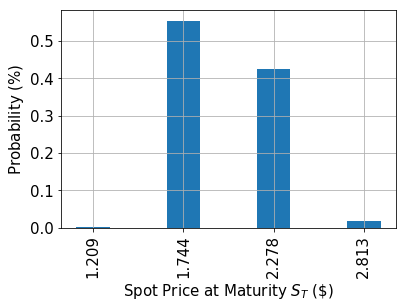

In [3]:
# plot probability distribution
x = uncertainty_model.values
y = uncertainty_model.probabilities
plt.bar(x, y, width=0.2)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.grid()
plt.xlabel('Spot Price at Maturity $S_T$ (\$)', size=15)
plt.ylabel('Probability ($\%$)', size=15)
plt.show()

## Payoff Function

In [4]:
# set the strike price (should be within the low and the high value of the uncertainty)
strike_price = 2

# set the approximation scaling for the payoff function
c_approx = 0.5

# construct circuit factory for payoff function
european_call = EuropeanCallExpectedValue(
    uncertainty_model,
    strike_price=strike_price,
    c_approx=c_approx
)

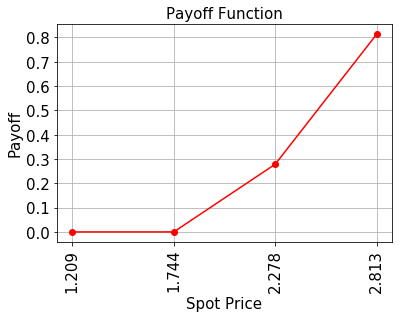

In [5]:
# plot payoff function (evaluated on the grid of the uncertainty model)
x = uncertainty_model.values
y = np.maximum(0, x - strike_price)
plt.plot(x, y, 'ro-')
plt.grid()
plt.title('Payoff Function', size=15)
plt.xlabel('Spot Price', size=15)
plt.ylabel('Payoff', size=15)
plt.xticks(x, size=15, rotation=90)
plt.yticks(size=15)
plt.show()

In [6]:
# evaluate exact expected value (normalized to the [0, 1] interval)
exact_value = np.dot(uncertainty_model.probabilities, y)
exact_delta = sum(uncertainty_model.probabilities[x >= strike_price])
print('exact (normalized) expected value:\t%.4f' % exact_value)
print('exact (normalized) delta value:   \t%.4f' % exact_delta)

exact (normalized) expected value:	0.1342
exact (normalized) delta value:   	0.4446


## Evaluate Expected Payoff

In [7]:
# set number of evaluation qubits (samples)
m = 2

# construct amplitude estimation 
ae = AmplitudeEstimation(m, european_call)

In [8]:
# result = ae.run(quantum_instance=Aer.get_backend('qasm_simulator_py'), shots=100)
result = ae.run(quantum_instance=Aer.get_backend('statevector_simulator_py'))

In [9]:
print('Exact value:    \t%.4f' % exact_value)
print('Estimated value:\t%.4f' % result['estimation'])
print('Probability:    \t%.4f' % result['max_probability'])

Exact value:    	0.1342
Estimated value:	0.5349
Probability:    	0.8564


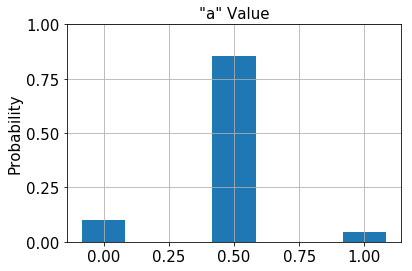

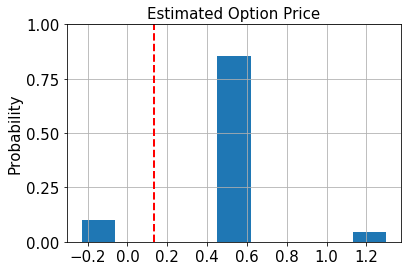

In [10]:
# plot estimated values for "a"
plt.bar(result['values'], result['probabilities'], width=0.5/len(result['probabilities']))
plt.xticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('"a" Value', size=15)
plt.ylabel('Probability', size=15)
plt.ylim((0,1))
plt.grid()
plt.show()

# plot estimated values for option price
plt.bar(result['mapped_values'], result['probabilities'], width=0.5/len(result['probabilities']))
plt.plot([exact_value, exact_value], [0,1], 'r--', linewidth=2)
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('Estimated Option Price', size=15)
plt.ylabel('Probability', size=15)
plt.ylim((0,1))
plt.grid()
plt.show()

## Evaluate Delta

In [11]:
european_call_delta = EuropeanCallDelta(
    uncertainty_model,
    strike_price
)

In [12]:
# set number of evaluation qubits (=log(samples)
m = 3

# construct amplitude estimation 
ae_delta = AmplitudeEstimation(m, european_call_delta)

In [13]:
# result_delta = ae_delta.run(quantum_instance=Aer.get_backend('qasm_simulator_py'), shots=100)
result_delta = ae_delta.run(quantum_instance=Aer.get_backend('statevector_simulator_py'))

In [14]:
print('Exact delta:   \t%.4f' % exact_delta)
print('Esimated value:\t%.4f' % result_delta['estimation'])
print('Probability:   \t%.4f' % result_delta['max_probability'])

Exact delta:   	0.4446
Esimated value:	0.5000
Probability:   	0.9399


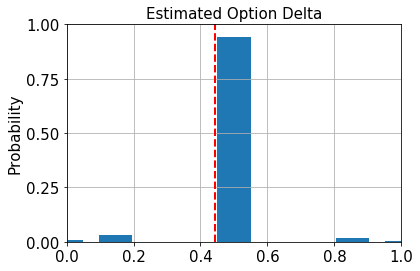

In [15]:
# plot estimated values for delta
plt.bar(result_delta['values'], result_delta['probabilities'], width=0.5/len(result_delta['probabilities']))
plt.plot([exact_delta, exact_delta], [0,1], 'r--', linewidth=2)
plt.xticks(size=15)
plt.yticks([0, 0.25, 0.5, 0.75, 1], size=15)
plt.title('Estimated Option Delta', size=15)
plt.ylabel('Probability', size=15)
plt.xlim((0,1))
plt.ylim((0,1))
plt.grid()
plt.show()